In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import datetime


In [3]:
dataset = pd.read_pickle("/mnt/b/Git_Projects/DOTA2Project/Stats_Data/small_dataset.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/b/Git_Projects/DOTA2Project/Stats_Data/small_dataset.pickle'

In [4]:
dataset.sample(10)

NameError: name 'dataset' is not defined

In [9]:
eval(dataset.columns)

TypeError: eval() arg 1 must be a string, bytes or code object

In [15]:
dataset.reset_index()["Radiant_win"].value_counts()

t    3752
f    3691
Name: Radiant_win, dtype: int64

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split

In [8]:
pipe = Pipeline([
    ("Imputer", SimpleImputer()),
    ("Scaler", StandardScaler()),
    ("LDA", LinearDiscriminantAnalysis(n_components=1))
])

In [9]:
transformed = pipe.fit_transform(dataset.iloc[:,:-2], dataset.loc[:, "Radiant_win"])

In [10]:
transformed = pd.DataFrame(transformed, index=dataset.index)
transformed["Radiant_win"] = dataset["Radiant_win"]

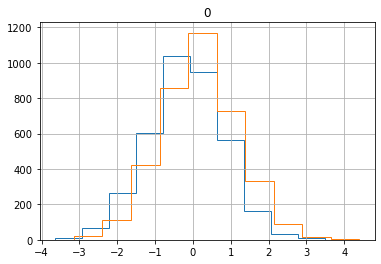

In [11]:
fig, ax = plt.subplots()

transformed.groupby("Radiant_win").hist(ax = ax, histtype="step");

# Keras

In [12]:
import tensorflow as tf 
import keras

from keras.wrappers.scikit_learn import KerasClassifier

In [13]:
X = dataset.iloc[:,:-2]
y = dataset.loc[:,"Radiant_win"]

Define the model below

In [14]:
def create_model():

    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=X.shape[1]))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dense(50, activation="relu"))
    model.add(keras.layers.Dense(20, activation="relu"))
    model.add(keras.layers.Dense(5, activation="relu"))
    model.add(keras.layers.Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

    return model

In [18]:
import kerastuner as kt

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

pipe = Pipeline([
    ("Imputer", SimpleImputer())#,
    #("Scaler", StandardScaler()),
    #("NN", KerasClassifier(build_fn=create_model, epochs=5))
])

y_bin = np.array([1 if i=="t" else 0 for i in y])


preprocessed = pd.DataFrame(pipe.fit_transform(X,y_bin), index=X.index, columns=X.columns)


create_model().fit(x=preprocessed,
y=y_bin,
validation_split=0.3,
epochs=5,
batch_size=32,
callbacks=[tensorboard_callback])

"""
cross_validate(pipe, X, y, scoring="accuracy", cv=5, fit_params={"callbacks":[tensorboard_callback]})
"""

Epoch 1/5
163/163 [==============================] - 1s 5ms/step - loss: 0.6944 - accuracy: 0.5035 - val_loss: 0.6938 - val_accuracy: 0.5060
Epoch 2/5
163/163 [==============================] - 1s 9ms/step - loss: 0.6918 - accuracy: 0.5184 - val_loss: 0.6939 - val_accuracy: 0.5007
Epoch 3/5
163/163 [==============================] - 1s 7ms/step - loss: 0.6906 - accuracy: 0.5265 - val_loss: 0.6948 - val_accuracy: 0.5092
Epoch 4/5
163/163 [==============================] - 1s 6ms/step - loss: 0.6851 - accuracy: 0.5499 - val_loss: 0.7061 - val_accuracy: 0.4908
Epoch 5/5
163/163 [==============================] - 1s 4ms/step - loss: 0.6782 - accuracy: 0.5726 - val_loss: 0.6995 - val_accuracy: 0.4993


'\ncross_validate(pipe, X, y, scoring="accuracy", cv=5, fit_params={"callbacks":[tensorboard_callback]})\n'

In [17]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 1578), started 0:29:47 ago. (Use '!kill 1578' to kill it.)

In [42]:
def create_model(hp):

    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=X.shape[1]))

    n_layers = hp.Int("n_layers", min_value=5,max_value=10)

    for layer_n in range(n_layers):

        n_nodes = hp.Int("n_nodes", min_value=5,max_value=20)
        model.add(keras.layers.Dense(n_nodes, activation="relu"))

    model.add(keras.layers.Dense(1,activation="sigmoid"))

    model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

    return model

In [43]:
tuner = kt.BayesianOptimization(create_model,
                     objective = 'val_accuracy',
                     max_trials = 10,
                     #factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3)

X_train_p = pd.DataFrame(pipe.fit_transform(X_train,y_train), index=X_train.index, columns=X_train.columns)
X_test_p = pd.DataFrame(pipe.fit_transform(X_test,y_test), index=X_test.index, columns=X_test.columns)

In [49]:
tuner.search(X_train_p,
y_train,
epochs=10,
validation_data=(X_test_p, y_test),
callbacks=[tensorboard_callback])


ValueError: All callbacks used during a search should be deep-copyable (since they are reused across trials). It is not possible to do `copy.deepcopy([<tensorflow.python.keras.callbacks.TensorBoard object at 0x7fbccc408730>])`

In [50]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

tuner.search(preprocessed,
y_bin,
validation_split=0.3,
epochs=5,
batch_size=32,
callbacks=[tensorboard_callback])

Epoch 1/5
  1/163 [..............................] - ETA: 0s - loss: 0.7159 - accuracy: 0.31  2/163 [..............................] - ETA: 10s - loss: 0.7082 - accuracy: 0.375  4/163 [..............................] - ETA: 7s - loss: 0.7007 - accuracy: 0.42 18/163 [==>...........................] - ETA: 2s - loss: 0.6951 - accuracy: 0.47 32/163 [====>.........................] - ETA: 1s - loss: 0.6950 - accuracy: 0.47 44/163 [=======>......................] - ETA: 0s - loss: 0.6946 - accuracy: 0.47 56/163 [=========>....................] - ETA: 0s - loss: 0.6942 - accuracy: 0.49 68/163 [===========>..................] - ETA: 0s - loss: 0.6941 - accuracy: 0.49 82/163 [==============>...............] - ETA: 0s - loss: 0.6937 - accuracy: 0.50 94/163 [================>.............] - ETA: 0s - loss: 0.6938 - accuracy: 0.49100/163 [=================>............] - ETA: 0s - loss: 0.6937 - accuracy: 0.49111/163 [===================>..........] - ETA: 0s - loss: 0.6937 - accuracy: 0.49119/

 loss: 0.6939 - accuracy: 0.49143/163 [=========================>....] - ETA: 0s - loss: 0.6936 - accuracy: 0.50151/163 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.50155/163 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.50158/163 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.50161/163 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.50163/163 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.50163/163 [==============================] - 2s 15ms/step - loss: 0.6934 - accuracy: 0.5079 - val_loss: 0.6933 - val_accuracy: 0.4980
Epoch 2/5
  1/163 [..............................] - ETA: 0s - loss: 0.6910 - accuracy: 0.62 10/163 [>.............................] - ETA: 0s - loss: 0.6897 - accuracy: 0.55 21/163 [==>...........................] - ETA: 0s - loss: 0.6912 - accuracy: 0.52 24/163 [===>..........................] - ETA: 0s - loss: 0.6915 - accuracy: 0.52 25/163 

cy: 0.51 20/163 [==>...........................] - ETA: 4s - loss: 0.6931 - accuracy: 0.51 21/163 [==>...........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.51 22/163 [===>..........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.51 24/163 [===>..........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.52 27/163 [===>..........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.51 30/163 [====>.........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.51 31/163 [====>.........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.52 32/163 [====>.........................] - ETA: 4s - loss: 0.6930 - accuracy: 0.52 33/163 [=====>........................] - ETA: 5s - loss: 0.6930 - accuracy: 0.51 36/163 [=====>........................] - ETA: 4s - loss: 0.6931 - accuracy: 0.51 40/163 [======>.......................] - ETA: 4s - loss: 0.6931 - accuracy: 0.51 43/163 [======>.......................] - ETA: 4s - loss: 0.6931 - accuracy: 0.51 45/163 

125/163 [======================>.......] - ETA: 0s - loss: 0.6933 - accuracy: 0.49128/163 [======================>.......] - ETA: 0s - loss: 0.6933 - accuracy: 0.49137/163 [========================>.....] - ETA: 0s - loss: 0.6933 - accuracy: 0.49142/163 [=========================>....] - ETA: 0s - loss: 0.6933 - accuracy: 0.49146/163 [=========================>....] - ETA: 0s - loss: 0.6933 - accuracy: 0.49149/163 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.49150/163 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.49151/163 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.49153/163 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.49154/163 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.49155/163 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.49156/163 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.49158/163 [=======

cy: 0.51161/163 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.51162/163 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.51163/163 [==============================] - 7s 44ms/step - loss: 0.6928 - accuracy: 0.5109 - val_loss: 0.6926 - val_accuracy: 0.5114
Epoch 3/5
  1/163 [..............................] - ETA: 0s - loss: 0.6985 - accuracy: 0.37  4/163 [..............................] - ETA: 2s - loss: 0.6933 - accuracy: 0.46  6/163 [>.............................] - ETA: 6s - loss: 0.6933 - accuracy: 0.48  7/163 [>.............................] - ETA: 6s - loss: 0.6927 - accuracy: 0.50  8/163 [>.............................] - ETA: 7s - loss: 0.6920 - accuracy: 0.51 11/163 [=>............................] - ETA: 5s - loss: 0.6919 - accuracy: 0.52 14/163 [=>............................] - ETA: 5s - loss: 0.6922 - accuracy: 0.51 16/163 [=>............................] - ETA: 4s - loss: 0.6918 - accuracy: 0.52 19/163 [==>..................

6/163 [============>.................] - ETA: 3s - loss: 0.6926 - accuracy: 0.51 77/163 [=============>................] - ETA: 3s - loss: 0.6929 - accuracy: 0.51 79/163 [=============>................] - ETA: 3s - loss: 0.6928 - accuracy: 0.51 80/163 [=============>................] - ETA: 3s - loss: 0.6929 - accuracy: 0.51 81/163 [=============>................] - ETA: 3s - loss: 0.6931 - accuracy: 0.51 82/163 [==============>...............] - ETA: 3s - loss: 0.6931 - accuracy: 0.50 84/163 [==============>...............] - ETA: 3s - loss: 0.6931 - accuracy: 0.50 86/163 [==============>...............] - ETA: 3s - loss: 0.6930 - accuracy: 0.51 87/163 [===============>..............] - ETA: 3s - loss: 0.6930 - accuracy: 0.51 88/163 [===============>..............] - ETA: 3s - loss: 0.6931 - accuracy: 0.50 91/163 [===============>..............] - ETA: 3s - loss: 0.6931 - accuracy: 0.50 95/163 [================>.............] - ETA: 3s - loss: 0.6932 - accuracy: 0.50 97/163 [=========

=======>.................] - ETA: 1s - loss: 0.6926 - accuracy: 0.50 75/163 [============>.................] - ETA: 1s - loss: 0.6925 - accuracy: 0.50 76/163 [============>.................] - ETA: 1s - loss: 0.6924 - accuracy: 0.51 82/163 [==============>...............] - ETA: 1s - loss: 0.6926 - accuracy: 0.50 87/163 [===============>..............] - ETA: 1s - loss: 0.6927 - accuracy: 0.50 92/163 [===============>..............] - ETA: 1s - loss: 0.6926 - accuracy: 0.51 94/163 [================>.............] - ETA: 1s - loss: 0.6926 - accuracy: 0.51 98/163 [=================>............] - ETA: 1s - loss: 0.6927 - accuracy: 0.50101/163 [=================>............] - ETA: 1s - loss: 0.6926 - accuracy: 0.50102/163 [=================>............] - ETA: 1s - loss: 0.6926 - accuracy: 0.50103/163 [=================>............] - ETA: 1s - loss: 0.6925 - accuracy: 0.51106/163 [==================>...........] - ETA: 1s - loss: 0.6924 - accuracy: 0.51107/163 [==================>..

cy: 0.50163/163 [==============================] - 5s 33ms/step - loss: 0.6934 - accuracy: 0.5044 - val_loss: 0.6927 - val_accuracy: 0.5056
Epoch 3/5
  1/163 [..............................] - ETA: 0s - loss: 0.6903 - accuracy: 0.53  4/163 [..............................] - ETA: 2s - loss: 0.6934 - accuracy: 0.47  5/163 [..............................] - ETA: 3s - loss: 0.6932 - accuracy: 0.48  7/163 [>.............................] - ETA: 3s - loss: 0.6922 - accuracy: 0.52 10/163 [>.............................] - ETA: 3s - loss: 0.6924 - accuracy: 0.51 13/163 [=>............................] - ETA: 3s - loss: 0.6926 - accuracy: 0.50 15/163 [=>............................] - ETA: 3s - loss: 0.6922 - accuracy: 0.52 16/163 [=>............................] - ETA: 3s - loss: 0.6924 - accuracy: 0.51 18/163 [==>...........................] - ETA: 3s - loss: 0.6929 - accuracy: 0.50 19/163 [==>...........................] - ETA: 4s - loss: 0.6929 - accuracy: 0.50 22/163 [===>.................

....] - ETA: 3s - loss: 0.6927 - accuracy: 0.51103/163 [=================>............] - ETA: 3s - loss: 0.6928 - accuracy: 0.51104/163 [==================>...........] - ETA: 3s - loss: 0.6928 - accuracy: 0.51105/163 [==================>...........] - ETA: 3s - loss: 0.6928 - accuracy: 0.51106/163 [==================>...........] - ETA: 3s - loss: 0.6928 - accuracy: 0.51107/163 [==================>...........] - ETA: 3s - loss: 0.6929 - accuracy: 0.51109/163 [===================>..........] - ETA: 3s - loss: 0.6930 - accuracy: 0.51110/163 [===================>..........] - ETA: 3s - loss: 0.6930 - accuracy: 0.51111/163 [===================>..........] - ETA: 3s - loss: 0.6930 - accuracy: 0.51112/163 [===================>..........] - ETA: 3s - loss: 0.6930 - accuracy: 0.50114/163 [===================>..........] - ETA: 2s - loss: 0.6930 - accuracy: 0.51115/163 [====================>.........] - ETA: 2s - loss: 0.6930 - accuracy: 0.51116/163 [====================>.........] - ETA: 2s 

ccuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 3/5
  1/163 [..............................] - ETA: 0s - loss: 0.6931 - accuracy: 0.50  3/163 [..............................] - ETA: 6s - loss: 0.6929 - accuracy: 0.46  4/163 [..............................] - ETA: 9s - loss: 0.6927 - accuracy: 0.48  7/163 [>.............................] - ETA: 6s - loss: 0.6928 - accuracy: 0.49  9/163 [>.............................] - ETA: 6s - loss: 0.6930 - accuracy: 0.49 10/163 [>.............................] - ETA: 6s - loss: 0.6932 - accuracy: 0.48 11/163 [=>............................] - ETA: 7s - loss: 0.6933 - accuracy: 0.49 12/163 [=>............................] - ETA: 7s - loss: 0.6933 - accuracy: 0.48 13/163 [=>............................] - ETA: 7s - loss: 0.6932 - accuracy: 0.48 14/163 [=>............................] - ETA: 7s - loss: 0.6931 - accuracy: 0.48 15/163 [=>............................] - ETA: 7s - loss: 0.6930 - accuracy: 0.49 16/163 [=>...................

INFO:tensorflow:Oracle triggered exit
